In [1]:
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
tf.keras.backend.set_floatx('float32')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Normalize the images, between 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
#(60000, 28, 28, 1)

print(y_train.shape)
(60000,)

print(x_test.shape)
#(10000, 28, 28, 1)

print(y_test.shape)
#(10000,)

num_class = 10

# Convert labels to one hot encoded vectors.
y_train_oh, y_test_oh = tf.keras.utils.to_categorical(y_train, num_classes= num_class, dtype='float32'), tf.keras.utils.to_categorical(y_test, num_classes= num_class, dtype='float32')

print(y_train_oh.shape)
#(60000, 10)
print(y_test_oh.shape)
#(10000, 10)

batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_oh)).shuffle(10000).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_oh)).batch(batch_size)

TensorFlow version:  2.1.0
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)
(60000, 10)
(10000, 10)


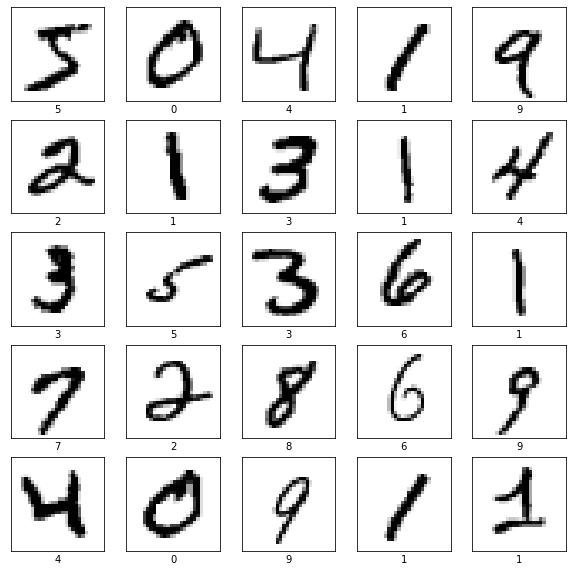

In [2]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_train[i]), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [3]:
# IMG_SIZE = (28, 28, 1)
# input_img = tf.keras.layers.Input(shape=IMG_SIZE)

# hidden_layer_1 = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides=(1, 1), padding='same', activation=tf.nn.relu)(input_img)
# hidden_layer_2 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides=(2, 2), padding='same', activation=tf.nn.relu)(hidden_layer_1)
# hidden_layer_3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides=(2, 2), padding='same', activation=tf.nn.relu)(hidden_layer_2)

# flatten_layer = tf.keras.layers.Flatten()(hidden_layer_3)
# output_img = tf.keras.layers.Dense(num_class)(flatten_layer)
# #NO SOFTMAX LAYER IN THE END, WE WILL DO IT LATER
# #predictions = tf.nn.softmax(logits)

# model = tf.keras.Model(input_img, output_img)

# model.summary()


IMG_SIZE = (28, 28, 1)
input_img = tf.keras.layers.Input(shape=IMG_SIZE)

x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=(2, 2), activation = 'relu')(x)

x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=(2, 2), activation = 'relu')(x)

x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation = 'relu')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation = 'relu')(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
output_img = tf.keras.layers.Dense(10, activation=None)(x)
#NO SOFTMAX LAYER IN THE END, WE WILL DO IT LATER
#predictions = tf.nn.softmax(logits)

model = tf.keras.Model(input_img, output_img)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          36928 

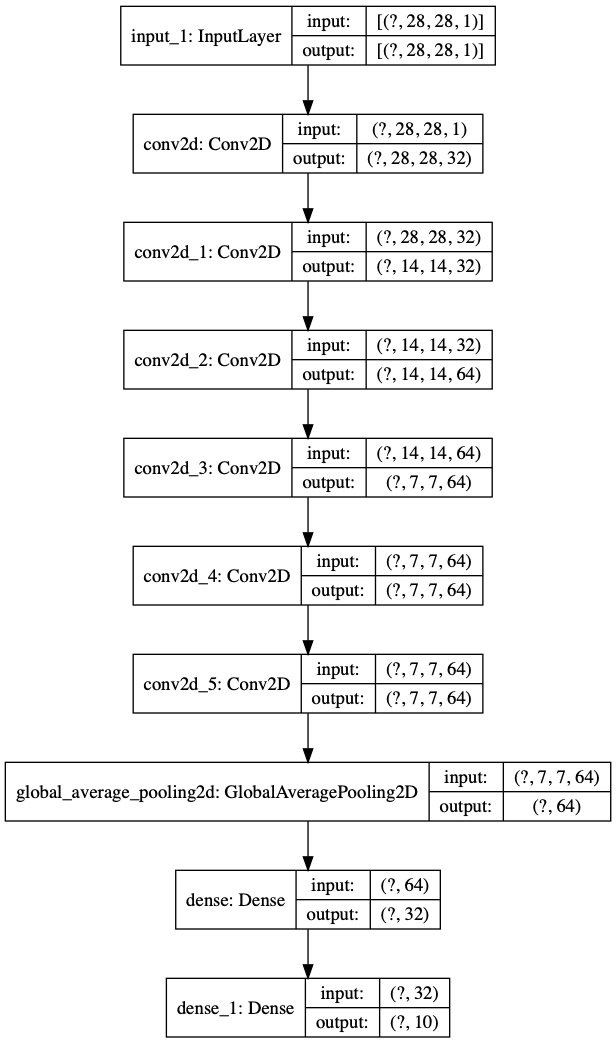

In [4]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [5]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# This function accepts one-hot encoded labels

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    
# Train the model for 15 epochs.
num_epochs = 15

train_loss_results = []
train_accuracy_results = []
test_loss_results = []
test_accuracy_results = []

for epoch in range(num_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    train_loss_results.append(train_loss.result())
    train_accuracy_results.append(train_accuracy.result())
    test_loss_results.append(test_loss.result())
    test_accuracy_results.append(test_accuracy.result())

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
    
tf.keras.models.save_model(model = model, filepath = 'model.h5', overwrite=True, include_optimizer=True)


W0410 16:25:50.843611 4668329408 base_layer.py:1790] Layer conv2d is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Epoch 1, Loss: 0.3522980511188507, Accuracy: 88.41666412353516, Test Loss: 0.09810767322778702, Test Accuracy: 96.81999969482422
Epoch 2, Loss: 0.08404541015625, Accuracy: 97.49166107177734, Test Loss: 0.050415974110364914, Test Accuracy: 98.36000061035156
Epoch 3, Loss: 0.05699312314391136, Accuracy: 98.25833129882812, Test Loss: 0.04067734628915787, Test Accuracy: 98.72000122070312
Epoch 4, Loss: 0.044057898223400116, Accuracy: 98.6883316040039, Test Loss: 0.03578612580895424, Test Accuracy: 98.90999603271484
Epoch 5, Loss: 0.03423496335744858, Accuracy: 98.98666381835938, Test Loss: 0.06282813847064972, Test Accuracy: 97.94999694824219
Epoch 6, Loss: 0.027973709627985954, Accuracy: 99.11000061035156, Test Loss: 0.024953795596957207, Test Accuracy: 99.16999816894531
Epoch 7, Loss: 0.023575885221362114, Accuracy: 99.2316665649414, Test Loss: 0.0349382646381855, Test Accuracy: 98.91999816894531
Epoch 8, Loss: 0.0193238016217947, Accuracy: 99.40499877929688, Test Loss: 0.024207303300499

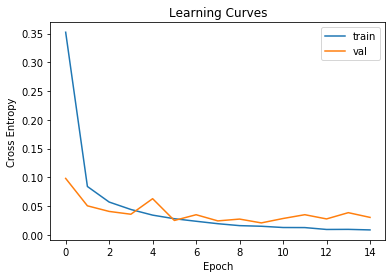

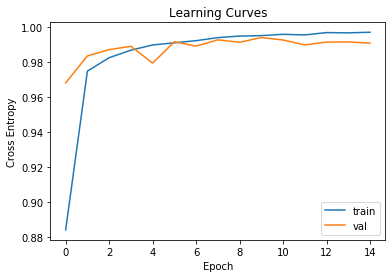

In [6]:
plt.figure(1)
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(train_loss_results, label='train')
plt.plot(test_loss_results, label='val')
plt.legend()
plt.show()

plt.figure(2)
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(train_accuracy_results, label='train')
plt.plot(test_accuracy_results, label='val')
plt.legend()
plt.show()


For generating and studying adversarial attacks, let's select ten correctly classified digit 2.

In [7]:
# Select 10 samples of digit two from the training set.
num_images = 10
mnist_twos = x_train[np.where(y_train == 2)][:num_images]
#(10, 28, 28, 1)

predictions = model(mnist_twos, training=False)
orig_preds = []
orig_probs = []

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx] #probabilities
    print("Example {} prediction: {} ({:4.1f}%)".format(i, class_idx, 100*p))
    orig_preds.append(class_idx)
    orig_probs.append(p.numpy())

Example 0 prediction: 2 (100.0%)
Example 1 prediction: 2 (100.0%)
Example 2 prediction: 2 (100.0%)
Example 3 prediction: 2 (100.0%)
Example 4 prediction: 2 (100.0%)
Example 5 prediction: 2 (100.0%)
Example 6 prediction: 2 (100.0%)
Example 7 prediction: 2 (100.0%)
Example 8 prediction: 2 (91.8%)
Example 9 prediction: 2 (100.0%)


#  Jacobian Saliency Map Approach: JSMA (L0, Targeted)

Papernot et al. (https://arxiv.org/abs/1511.07528) proposed the Jacobian-based saliency map approach (JSMA) to search for adversarial examples by only modifying a limited number of input pixels in an image. As a targeted attack, JSMA iteratively perturbs pixels in an input image that have high adversarial saliency scores. The process is repeated until classification into the target class is achieved, or it reaches the maximum number of perturbed pixels

In [8]:
advs_jsma, perts_jsma = [], []
target=6
eps = 0.5
n_class = 10
cmin = 0.0
cmax = 1.0
iters = 100

for i, img in enumerate(mnist_twos):
    X_adv = tf.convert_to_tensor(img, dtype=tf.float32) #shape=(28, 28, 1)
    
    for j in range(iters):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(X_adv)
            logits = model(tf.reshape(X_adv, shape=(-1,28,28,1)), training=False) # shape=(1, 10)
            logits = tf.reshape(logits, (-1,)) # shape=(10,)
            
        jacobian = tape.jacobian(logits, X_adv)
        del tape
        
        y_ind = tf.argmax(logits).numpy() #scalar
        grad_input = jacobian[y_ind]
        grad_target = jacobian[target]
        
        grad_other = grad_input - grad_target
        
        c1 = tf.logical_or(eps < 0, X_adv < cmax)
        c2 = tf.logical_or(eps > 0, X_adv > cmin)

        # Check saliency map conditions.
        c3 = grad_target >= 0
        c4 = grad_other <= 0
    
        cond = tf.cast(tf.reduce_all([c1, c2, c3, c4], axis=0), dtype=tf.float32)
        score = cond * (grad_target * grad_other)
        
        # Return score for each pixel
        score = tf.reshape(score, shape=[1, 784])
        #<tf.Tensor 'Reshape_11:0' shape=(1, 784) dtype=float32>
        
        idx = tf.argmax(score, axis=1)

        pert = tf.one_hot(idx, 784, on_value=eps, off_value=0.0)
        pert = tf.reshape(pert, shape=tf.shape(X_adv))
        #<tf.Tensor 'Reshape_12:0' shape=(28, 28, 1) dtype=float32>
        
        X_adv = tf.clip_by_value(t = X_adv + pert, clip_value_min = cmin, clip_value_max = cmax)

    perturbation = X_adv.numpy() - img
    
    advs_jsma.append(X_adv.numpy().reshape(28,28))
    perts_jsma.append(perturbation.reshape(28,28))

In [9]:
predictions_jsma = model(np.array(advs_jsma).reshape(num_images,28,28,1), training=False)

preds_jsma = []
probs_jsma =[]

for i, logits_jsma in enumerate(predictions_jsma):
    class_idx_jsma = tf.argmax(logits_jsma).numpy()
    p_jsma = tf.nn.softmax(logits_jsma)[class_idx_jsma] #probabilities
    print("Example {} prediction: {} ({:4.1f}%)".format(i, class_idx_jsma, 100*p_jsma))
    preds_jsma.append(class_idx_jsma)
    probs_jsma.append(p_jsma.numpy())

Example 0 prediction: 2 (100.0%)
Example 1 prediction: 2 (100.0%)
Example 2 prediction: 2 (100.0%)
Example 3 prediction: 2 (100.0%)
Example 4 prediction: 2 (100.0%)
Example 5 prediction: 2 (100.0%)
Example 6 prediction: 2 (100.0%)
Example 7 prediction: 2 (100.0%)
Example 8 prediction: 2 (91.3%)
Example 9 prediction: 2 (100.0%)


In [10]:
def plot_adversarials(origs, perturbs, advs , orig_preds, orig_probs, adv_probs, adv_preds, eps):
    
    fig, axes = plt.subplots(ncols=3, nrows=num_images, figsize=(18,18))

    for i in range(num_images):
        confidence = str(round(orig_probs[i],2))
        pixels = origs[i].reshape((28, 28))
        axes[i][0].imshow(pixels, cmap='gray')
        axes[i][0].set_axis_off()
        title = 'Original\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
        axes[i][0].set_title(title.format(orig_preds[i], confidence))

        pixels = perturbs[i].reshape((28, 28))
        axes[i][1].imshow(pixels, cmap='gray')
        axes[i][1].set_axis_off()
        title = 'Perturbations\n Epsilon: {}' if i==0 else 'Epsilon: {}'
        axes[i][1].set_title(title.format(eps))

        confidence = str(round(adv_probs[i],2))
        pixels = advs[i].reshape((28, 28))
        axes[i][2].imshow(pixels, cmap='gray')
        axes[i][2].set_axis_off()
        title = 'Adversarial\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
        axes[i][2].set_title(title.format(adv_preds[i], confidence))

    plt.show()

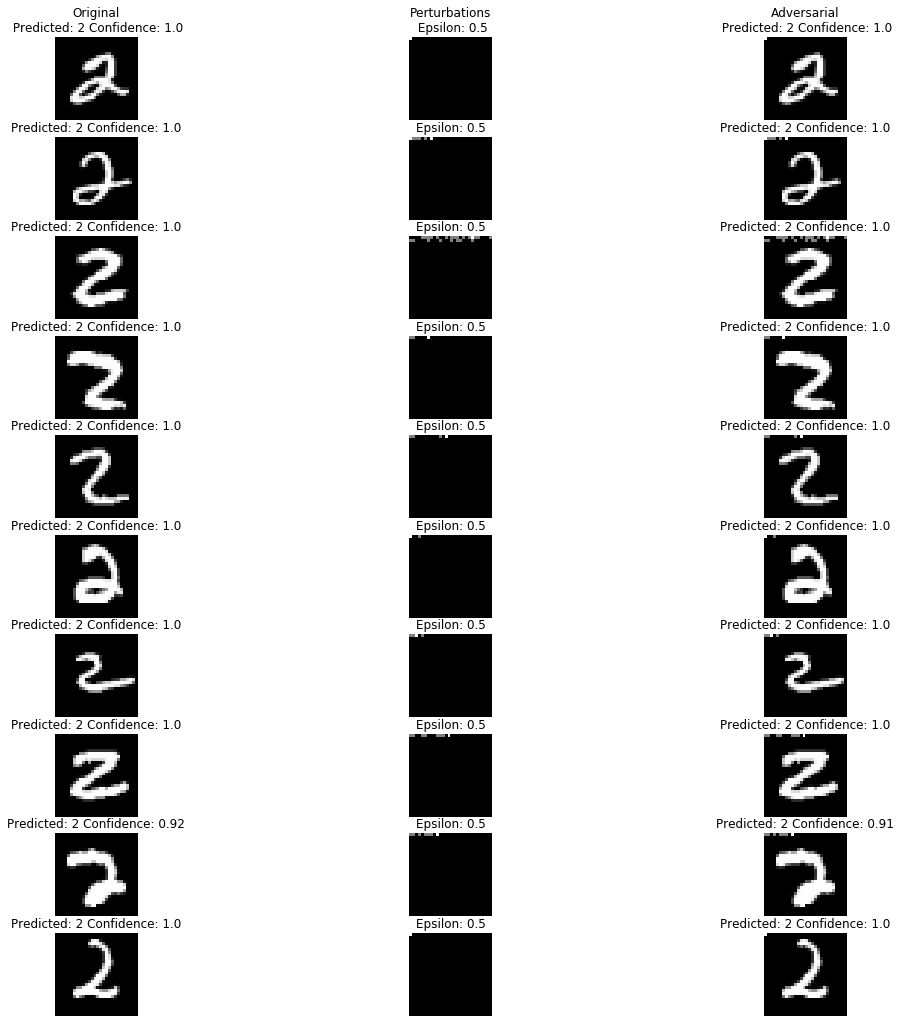

In [11]:
plot_adversarials(mnist_twos, np.array(perts_jsma), np.array(advs_jsma), orig_preds, orig_probs, probs_jsma, preds_jsma, eps=0.5)